In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
data = pd.read_csv("fraud data.csv")


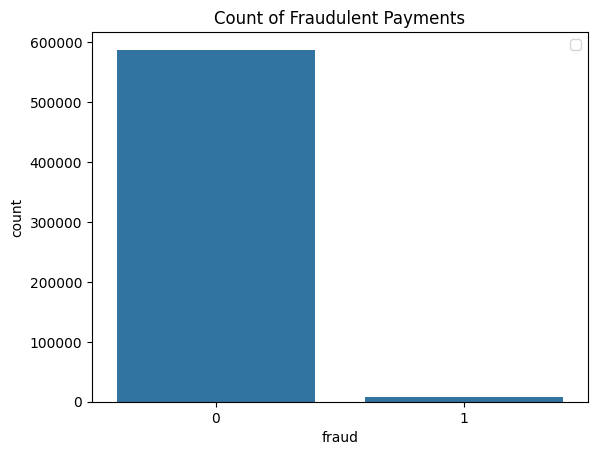

Number of normal examples:  587443
Number of fradulent examples:  7200
Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594
Columns:  Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMercha

In [ ]:
data.head(5)

# Create two dataframes with fraud and non-fraud data
df_fraud = data.loc[data.fraud == 1]
df_non_fraud = data.loc[data.fraud == 0]


sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.legend()
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
#print(data.fraud.value_counts()) # does the same thing above

print("Mean feature values per category",data.groupby('category')[['amount','fraud']].mean())

print("Columns: ", data.columns)

In [ ]:
print(data.zipcodeOri.nunique())
print(data.zipMerchant.nunique())

# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

data_reduced.columns

# turning object columns type to categorical for later purposes
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')

# it's usually better to turn the categorical values (customer, merchant, and category variables  )
# into dummies because they have no relation in size(i.e. 5>4) but since they are too many (over 500k) the features will grow too many and
# it will take forever to train but here is the code below for turning categorical features into dummies
#data_reduced.loc[:,['customer','merchant','category']].astype('category')
#data_dum = pd.get_dummies(data_reduced.loc[:,['customer','merchant','category','gender']],drop_first=True) # dummies
#print(data_dum.info())

# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)

# define X and y
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']


# I won't do cross validation since we have a lot of instances
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True,stratify=y)


1
1


In [ ]:
def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# The base score should be better than predicting always non-fraduelent
print("Base score we must beat is: ",
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)



Base score we must beat is:  98.7891894800746


Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    176233
           1       0.83      0.61      0.70      2160

    accuracy                           0.99    178393
   macro avg       0.91      0.80      0.85    178393
weighted avg       0.99      0.99      0.99    178393

Confusion Matrix of K-Nearest Neigbours: 
 [[175962    271]
 [   845   1315]]


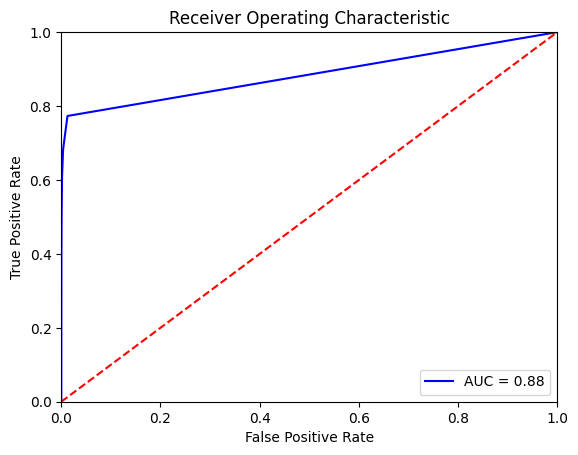

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

# High precision on fraudulent examples almost perfect score on non-fraudulent examples
print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    176233
           1       0.24      0.98      0.39      2160

    accuracy                           0.96    178393
   macro avg       0.62      0.97      0.68    178393
weighted avg       0.99      0.96      0.97    178393

Confusion Matrix of Random Forest Classifier: 
 [[169519   6714]
 [    40   2120]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


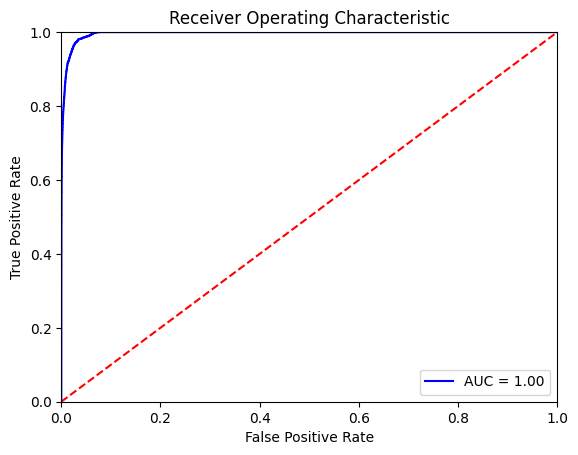

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

# 98 % recall on fraudulent examples but low 24 % precision.
print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:45:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    176233
           1       0.87      0.77      0.82      2160

    accuracy                           1.00    178393
   macro avg       0.93      0.88      0.91    178393
weighted avg       1.00      1.00      1.00    178393

Confusion Matrix of XGBoost: 
 [[175990    243]
 [   505   1655]]


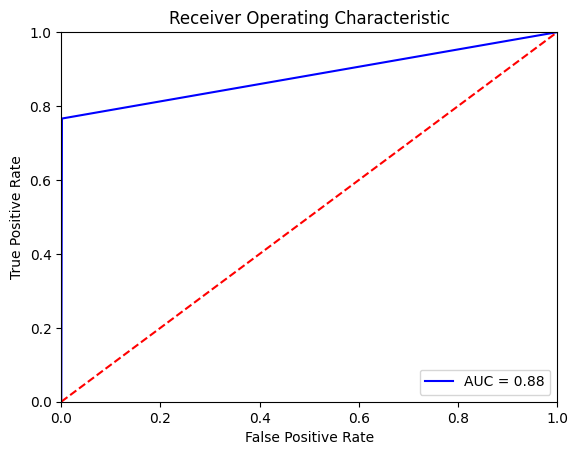

In [ ]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400,
                                objective="binary:hinge", booster='gbtree',
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0,
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1,
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1) # Changed verbosity to 1
XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

# reatively high precision and recall for fraudulent class
print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred)) # Accuracy for XGBoost:  0.9963059088641371
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.7s
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:46:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


Classification Report for Ensembled Models: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.47      0.92      0.62      2160

    accuracy                           0.99    178393
   macro avg       0.74      0.95      0.81    178393
weighted avg       0.99      0.99      0.99    178393

Confusion Matrix of Ensembled Models: 
 [[174016   2217]
 [   174   1986]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


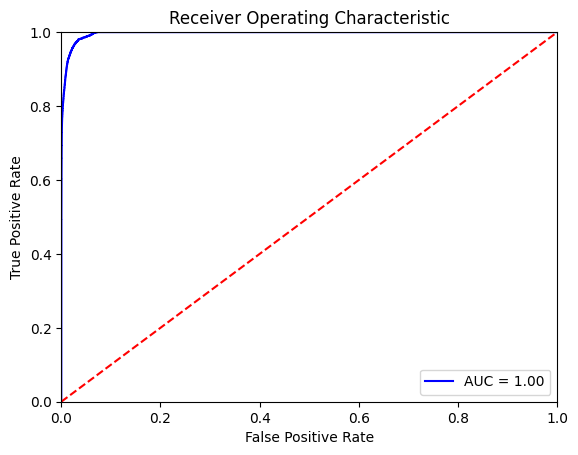

In [ ]:
estimators = [("KNN",knn),("rf",rf_clf),("xgb",XGBoost_CLF)]
ens = VotingClassifier(estimators=estimators, voting="soft",weights=[1,4,1])

ens.fit(X_train,y_train)
y_pred = ens.predict(X_test)


# Combined Random Forest model's recall and other models' precision thus this model
# ensures a higher recall with less false alarms (false positives)
print("Classification Report for Ensembled Models: \n", classification_report(y_test, y_pred)) # Accuracy for XGBoost:  0.9963059088641371
print("Confusion Matrix of Ensembled Models: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, ens.predict_proba(X_test)[:,1])